<a href="https://colab.research.google.com/github/Nivratti/100-Days-Of-ML-Code/blob/master/face_recognition_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Recognition System Using FaceNet in Keras
---


1.   extract multiple faces from image
2.   Separate files for train and test faces dataset
3.   CNN classifier




## **Connect Google Colab with Google Drive**

---



In [0]:
from google.colab import drive

In [4]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
!ls "/content/gdrive/My Drive/deep_learning/mtcnn_face_recognition"

5-celebrity-faces-dataset  facenet_keras.h5  img  output


##  Tensorflow with GPU

## Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [6]:
%tensorflow_version 1.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

TensorFlow 1.x selected.
Found GPU at: /device:GPU:0


### **Train**


In [11]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 6.5MB/s 


In [0]:
# face detection for the 5 Celebrity Faces Dataset
from os import listdir
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
from numpy import savez_compressed
from numpy import asarray
from mtcnn.mtcnn import MTCNN

In [13]:
# create the detector, using default weights
detector = MTCNN()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [0]:
# extract a single face from a given photograph
def extract_faces(filename, required_size=(160, 160)):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)

	# detect faces in the image
	results = detector.detect_faces(pixels)

	faces = []
	for result in results:
		# extract the bounding box from the first face
		x1, y1, width, height = result['box']
		# bug fix
		x1, y1 = abs(x1), abs(y1)
		x2, y2 = x1 + width, y1 + height
		# extract the face
		face = pixels[y1:y2, x1:x2]
		# resize pixels to the model size
		image = Image.fromarray(face)
		image = image.resize(required_size)
		face_array = asarray(image)
		faces.append(face_array)
	return faces
 
# load images and extract faces for all images in a directory
def load_faces(directory):
	all_faces = list()
	# enumerate files
	for filename in listdir(directory):
		# path
		path = directory + filename
		# get face
		faces = extract_faces(path)
		# store
		all_faces.extend(faces)
	return all_faces
 
# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
	X, y = list(), list()
	# enumerate folders, on per class
	for subdir in listdir(directory):
		# path
		path = directory + subdir + '/'
		# skip any files that might be in the dir
		if not isdir(path):
			continue
		# load all faces in the subdirectory
		faces = load_faces(path)
		# create labels
		labels = [subdir for _ in range(len(faces))]
		# summarize progress
		print('>loaded %d examples for class: %s' % (len(faces), subdir))
		# store
		X.extend(faces)
		y.extend(labels)
	return asarray(X), asarray(y)

In [0]:
import os

root_folder = '/content/gdrive/My Drive/deep_learning/mtcnn_face_recognition/'
dataset_folder = os.path.join(root_folder, "5-celebrity-faces-dataset/")


## **Detect Faces**


1 (160, 160, 3)
2 (160, 160, 3)
3 (160, 160, 3)
4 (160, 160, 3)
5 (160, 160, 3)
6 (160, 160, 3)
7 (160, 160, 3)
8 (160, 160, 3)
9 (160, 160, 3)
10 (160, 160, 3)
11 (160, 160, 3)
12 (160, 160, 3)
13 (160, 160, 3)
14 (160, 160, 3)


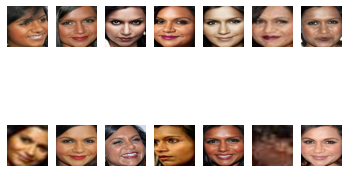

In [0]:
from os import listdir
from PIL import Image
from numpy import asarray
from matplotlib import pyplot
from mtcnn.mtcnn import MTCNN


# specify folder to plot
folder = os.path.join(dataset_folder, "train/mindy_kaling/")

i = 1
# enumerate files
for filename in listdir(folder):
    # path
    path = folder + filename
    # get face
    faces = extract_faces(path)
    for face in faces:
        print(i, face.shape)
        # plot
        pyplot.subplot(2, 7, i)
        pyplot.axis('off')
        pyplot.imshow(face)
        i += 1

    if i == 15:
        break
        
pyplot.show()

## generate face dataset

In [0]:
training_folder = os.path.join(dataset_folder, "train/")
validation_folder = os.path.join(dataset_folder, "val/")

# load train dataset
trainX, trainy = load_dataset(training_folder)
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset(validation_folder)

output_folder = os.path.join(root_folder, "output")
os.makedirs(output_folder, exist_ok=True)

faces_dataset_file = os.path.join(output_folder, "5-celebrity-faces-dataset.npz")

# save arrays to +one file in compressed format
savez_compressed(faces_dataset_file, trainX, trainy, testX, testy)

## Dataset

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [18]:
from numpy import load
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer

# load the face dataset
face_dataset_file = os.path.join(root_folder, "output/5-celebrity-faces-dataset.npz")
data = load(face_dataset_file)
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']

print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

total_classes = len(set(trainy))
print(f"Total classes : {total_classes}")

Loaded:  (98, 160, 160, 3) (98,) (28, 160, 160, 3) (28,)
Total classes : 5


In [19]:
trainX = trainX / 255.0
print(f"trainX.shape after normalization : {trainX.shape}")

trainX.shape after normalization : (98, 160, 160, 3)


In [20]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
encoded_trainy = encoder.fit_transform(trainy)
# print(encoded_trainy)
# transfomed_label = to_categorical(encoded_trainy, num_classes=total_classes)
# print(f"transfomed_label.shape : {encoded_trainy.shape}")

print(f"transfomed_label.shape : {encoded_trainy.shape}")

transfomed_label.shape : (98, 5)


In [21]:
testX = testX / 255.0
print(f"trainX.shape after normalization : {trainX.shape}")
encoded_testy = encoder.fit_transform(testy)
print(f"transfomed_label.shape : {encoded_testy.shape}")

trainX.shape after normalization : (98, 160, 160, 3)
transfomed_label.shape : (28, 5)


## CNN Model

In [30]:
from keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D

from keras import models

cnn_model= models.Sequential()
cnn_model.add(Conv2D(16, (3, 3), activation='relu', padding='same', 
                    input_shape=(160, 160,3)))
cnn_model.add(MaxPooling2D((2, 2), padding='same'))

cnn_model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
cnn_model.add(MaxPooling2D((2, 2), padding='same'))

cnn_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
cnn_model.add(MaxPooling2D((2, 2), padding='same'))

cnn_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
cnn_model.add(MaxPooling2D((2, 2), padding='same'))
cnn_model.add(GlobalAveragePooling2D())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(BatchNormalization())

cnn_model.add(Dense(5, activation='sigmoid'))

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', 
                 metrics=['accuracy'])

history = cnn_model.fit(trainX, encoded_trainy, epochs=201, validation_data=(testX, encoded_testy), batch_size=64)

Train on 98 samples, validate on 28 samples
Epoch 1/201
98/98 [==============================] - 1s 7ms/step - loss: 0.6940 - accuracy: 0.5571 - val_loss: 0.6836 - val_accuracy: 0.6714
Epoch 2/201
98/98 [==============================] - 0s 2ms/step - loss: 0.6554 - accuracy: 0.6306 - val_loss: 0.6819 - val_accuracy: 0.6714
Epoch 3/201
98/98 [==============================] - 0s 2ms/step - loss: 0.6475 - accuracy: 0.6490 - val_loss: 0.6803 - val_accuracy: 0.6571
Epoch 4/201
98/98 [==============================] - 0s 2ms/step - loss: 0.6372 - accuracy: 0.6612 - val_loss: 0.6788 - val_accuracy: 0.6214
Epoch 5/201
98/98 [==============================] - 0s 2ms/step - loss: 0.6224 - accuracy: 0.6878 - val_loss: 0.6757 - val_accuracy: 0.7000
Epoch 6/201
98/98 [==============================] - 0s 2ms/step - loss: 0.6099 - accuracy: 0.7020 - val_loss: 0.6726 - val_accuracy: 0.6929
Epoch 7/201
98/98 [==============================] - 0s 2ms/step - loss: 0.6000 - accuracy: 0.7061 - val_loss:

In [32]:
cnn_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 160, 160, 16)      448       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 80, 80, 16)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 80, 80, 32)        4640      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 40, 40, 64)        18496     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 20, 20, 128)      

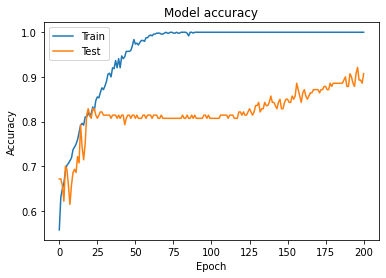

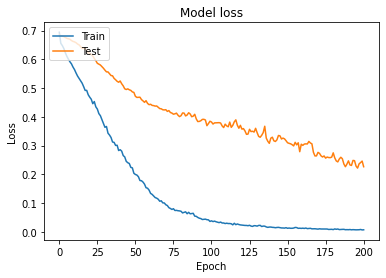

In [33]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()